我们已经知道卷积神经网络能够在机器视觉任务表现出色，原因在于它能够进行卷积运算，从局部输入图块中提取特征，并能够将表示模块化，同时可以高效地利用数据，这使得卷积神经网络在计算机视觉任务上表现优异。同时，这些特点也让卷积神经网络可以处理时间序列类的数据，典型如自然语言中的句子。对于某些序列处理/NLP处理任务，卷积网络的效果可以比肩RNN,而计算代价通常小很多，最近，一维卷积网络（与空洞卷积核Dilated Kernel一起使用）已经在语音识别和机器翻译领域取得了很好的效果，对于文本分类和时间序列预测这样的较为简单的任务，小型的一维卷积神经网络可以替代RNN, 而且速度更快。

# 序列数据的一维卷积

前面介绍的卷积都是二维卷积，从图像张量中提取二维图块，并对每个图块进行相同的变换。使用同样的方法，可以使用一维卷积，从序列数据中提取局部一维序列段（即子序列），如下图所示：

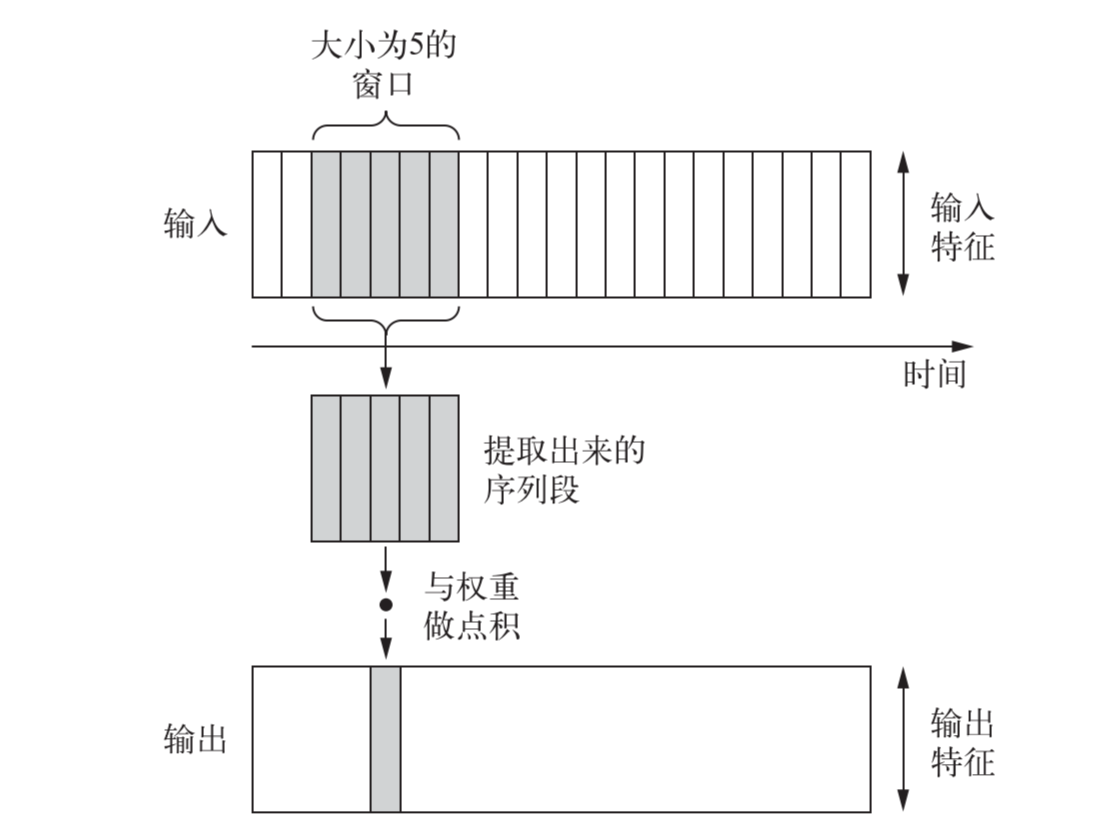

对于NLP任务，采用卷积神经网络进行处理时，卷积核的宽度与词向量的维度保持一致，这是因为我们输入的每一行向量，都代表一个词，在抽取特征的过程中，词作为文本的最小粒度，如果卷积核的宽度小于词向量的维度，那么就不是以词为单位了，而卷积核的高度可以自行设置（通常为2,3,4,5）。


这种一维卷积层可以识别序列中的局部模式，因为对每个序列段可以执行相同的输入变换，所以在句子中某个位置学到的模式，可以稍后在其他位置被识别。这使得一维卷积神经网络具有平移不变形（对于时间不变性而言）。举个例子，使用大小为5的卷积窗口，处理字符序列的一维卷积神经网络，应该能够学习到长度不大于5的单词或单词片段，并且应该能够在输入句子中的任何位置识别这些单词或单词段。因此，当我们用卷积核进行卷积时，不仅考虑了词义而且考虑了词序及其上下文

假设卷积网络输入的是一个表示句子的矩阵，句子长度为$n$, 词向量维度为$d$, 那么矩阵的形状就是$(n,d)$。假设$W_{i:i+j}$表示在这个句子中从$W_i$开始的$j+1$个词，如果使用一个宽度为$d$，高度为$h$的一维卷积核$K$，与从$W_i$开始的$h$个词$W_{i:i+h-1}$进行卷积计算，再用激活函数激活得到特征$C_i$,则卷积操作可以表示为：

$$C_i=f(K*W_{i:i+h-1}+b)$$

让这个卷积核从句子开始时从上往下移动，不断进行卷积运算，就可以得到这个卷积核在这个句子上的卷积计算输出特征。对于长度为$n$的句子，高度为$h$的卷积核进行卷积运算以后，可以得到$n-h+1$个特征值。

同样的，我们也可以使用更多高度不同的卷积核，且每个高度的卷积核多个，得到更多不同特征。



Keras中的一维卷积神经网络是Conv1D层，其接口类似Conv2D,定义一个一维卷积网络层的方法为：
```
Conv1d(filters, kernel_size, activation)

其中的参数为：
filters: 卷积核的个数
kernel_size: 卷积核的高度
activation: 卷积层使用的激活函数

```

它接受形状为(samples, time, features)的三维张量作为输入，并返回(samples, time-kernel_size+1, kernel_size)形状的三维张量，卷积窗口是时间轴上的一维窗口（时间轴是输入张量的第二个轴）

# 用TextCNN卷积网络进行句子分类

2014年Yoon Kim 在 “[Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)” 一文中提出一个用于句子分类的卷积神经网络TextCNN，如下图所示：

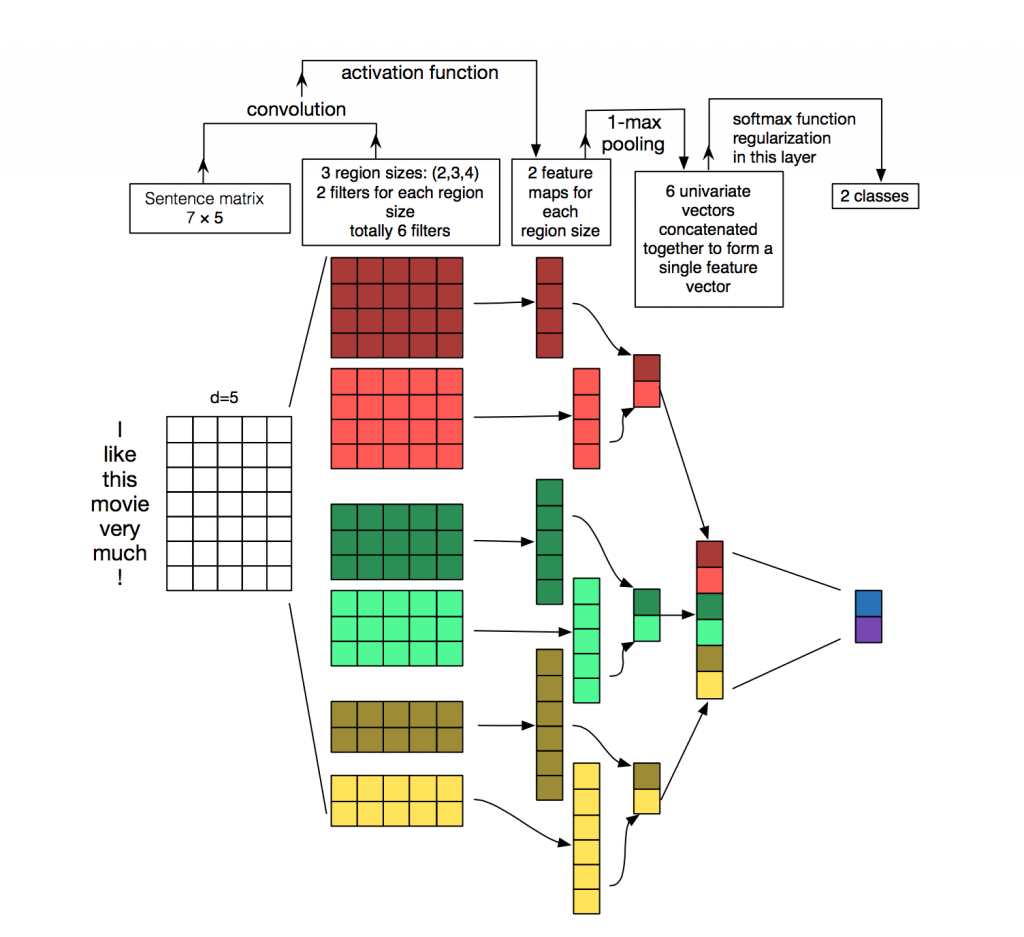·

在上图中，输入了一句话”I like this movie very much!”，其对应的句子矩阵维度为7*5，每个词用维度为5的词向量表示。在卷积层中，分别使用高度为4,3,2的一维卷积核，且每种卷积核有2个。卷积之后得到6个对应的特征向量，维度从上往下分别为4,4,5,5,6,6，然后对每个向量进行1-Max-pooling，再拼接起来一个维度为6的特征向量。最后通过全连接层，激活函数为softmax得到2个类别的概率。

在这篇论文中，作者对于输入的词向量尝试了以下几种不同的方式：

* CNN-rand: 随机初始化每个单词的词向量，通过后续的训练去调整。

* CNN-static: 使用预先训练好的词向量，如word2vec训练出来的词向量，在训练过程中不再调整该词向量。

* CNN-non-static: 使用预先训练好的词向量，并在训练过程进一步进行调整。

* CNN-multichannel: 将static与non-static作为两通道的词向量。

在论文中,作者在几个常见的句子分类公开数据集上进行了实验，结果如下图所示：
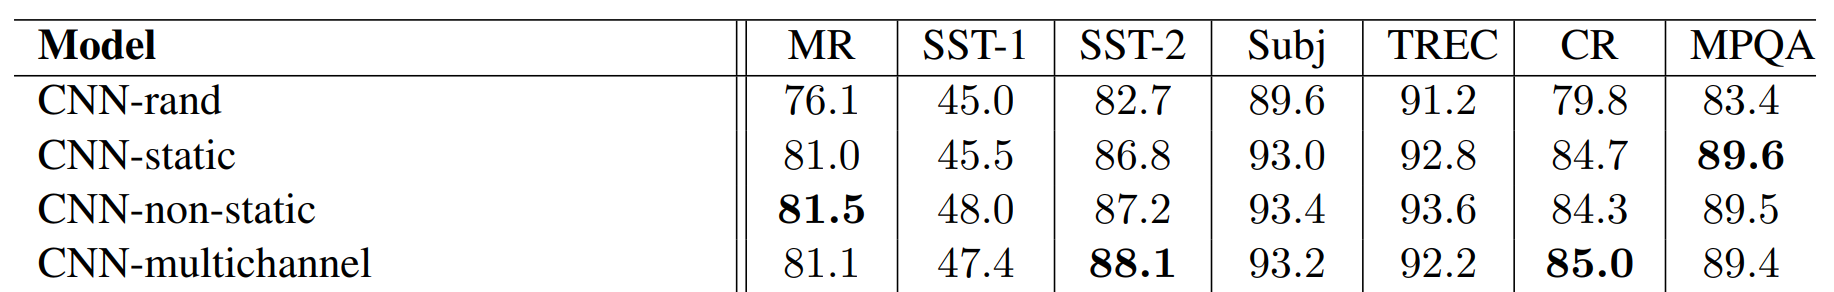

我们下面就用Keras来实现TextCNN网络，并对IMDB数据集进行分类，首先加载IMDB数据集:

In [2]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

vocab_size  = 10000             # 词典的大小设置为1万
max_sent_len = 256               # 设置句子的最大保留长度为256个标记

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=vocab_size)

# 将整数列表转化为形状为（samples，max_sent_len）的二维整数张量
x_train = pad_sequences(x_train, maxlen=max_sent_len)
x_test  = pad_sequences(x_test, maxlen=max_sent_len)

ValueError: Object arrays cannot be loaded when allow_pickle=False

然后我们来定义TextCNN网络，这里采用128位的嵌入式词向量随机初始化：

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.models import Model

def build_textcnn_model(maxlen=max_sent_len,max_features = vocab_size,embed_size=128  ):
    
    # Inputs
    sentence_seq = layers.Input(shape=[maxlen],name='sentence_input')
    
    # Embedding Layer
    emb_sentence = layers.Embedding(max_features,embed_size)(sentence_seq)
    
    # Conv Layer
    convs = []
    filter_sizes = [2,3,4,5,6,7]
    
    for size in filter_sizes:
        l_conv = layers.Conv1D(filters = 100,kernel_size=size, activation='relu')(emb_sentence)
        l_pool = layers.MaxPooling1D(maxlen-size+1)(l_conv)
        l_pool = layers.Flatten()(l_pool)
        convs.append(l_pool)
    
    merge = layers.concatenate(convs, axis=1)
    
    out = layers.Dropout(0.5)(merge)
    output = layers.Dense(32, activation='relu')(out)

    output = layers.Dense(units=1, activation='sigmoid')(output)
    
    model = Model([sentence_seq], output)
    
    return model
    

然后我们用Adam优化器训练模型：


In [ ]:
model = build_textcnn_model()
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [8]:
from keras.callbacks import ModelCheckpoint

batch_size = 128
epochs = 20

checkpoint_callback = ModelCheckpoint('best_textcnn.h5',
                                      monitor='val_acc',
                                      verbose=0,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='auto',
                                      period=1)

model.fit(x_train, y_train,
          validation_split=0.1,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          callbacks=[checkpoint_callback])



Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 239s 11ms/step - loss: 0.5109 - acc: 0.7214 - val_loss: 0.3074 - val_acc: 0.8760
Epoch 2/20
22500/22500 [==============================] - 241s 11ms/step - loss: 0.2607 - acc: 0.8912 - val_loss: 0.2468 - val_acc: 0.9076
Epoch 3/20
22500/22500 [==============================] - 237s 11ms/step - loss: 0.1583 - acc: 0.9409 - val_loss: 0.2542 - val_acc: 0.9088
Epoch 4/20
22500/22500 [==============================] - 237s 11ms/step - loss: 0.0825 - acc: 0.9726 - val_loss: 0.3028 - val_acc: 0.9004
Epoch 5/20
22500/22500 [==============================] - 236s 11ms/step - loss: 0.0389 - acc: 0.9880 - val_loss: 0.3589 - val_acc: 0.8968
Epoch 6/20
22500/22500 [==============================] - 237s 11ms/step - loss: 0.0236 - acc: 0.9932 - val_loss: 0.4130 - val_acc: 0.8972
Epoch 7/20
22500/22500 [==============================] - 236s 10ms/step - loss: 0.0123 - acc: 0.9966 - val_loss: 0.4

在测试集上看一下模型的效果：

In [9]:
model.load_weights('best_textcnn.h5')

scores = model.evaluate(x_test, y_test)
print('test_loss: %f, accuracy: %f' % (scores[0], scores[1]))

25000/25000 [==============================] - 74s 3ms/step
test_loss: 0.280127, accuracy: 0.888360


TextCNN使用一层的一维卷积进行文本分类，虽然模型很简单，但效果很不错，而且计算速度相比RNN要快很多(在我的笔记本上，对IMDB的一个句子进行分类耗时3ms左右)，所以在实际的工程项目中常被取代RNN作为实际的文本分类模型（淘宝的商品分类模型，即根据商品标题，对商品进行分类，就用过TextCNN模型）。而论文<[A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1510.03820.pdf)> 则通过大量实验，验证了TextCNN模型在文本分类任务中的调参技巧，给出实际项目应用的若干建议，如:

1. 采用非静态Word2Vec或Golve词向量作为输入
2. Kernel_size的合理值范围为1~10，对于长句子，可以尝试更大的Kernel_size
3. Feature Map的数量在100到600之间，可以从100开始尝试逐渐增加到600
4. 激活函数可以尝试Relu和Tanh
5. 当增加Feature Map的数量会降低模型性能时，尝试增加DropOut的值

# 卷积网络在自然语言处理任务中的问题及改进

虽然TextCNN在句子分类任务中表现不错，但一维卷积神经网络对序列的顺序不敏感(超出卷积核窗口大小的序列顺序)，而在自然语言的文本中，单词出现的前后顺序，对语义有明显的影响。所以，CNN模型本身在更为复杂的NLP任务中，一般效果不如更适合处理时间序列数据的RNN模型。然而，由于CNN模型的优良特性（尤其是方便并行计算），许多人对卷积网络进行了改进，以更适合自然语言和其他时间序列数据的任务。

首先，最常见的改进，就是k-max池化，K-max池化与之前的MaxPooling1D相比，最大的区别，就是不是返回一个最大值，而是返回$K$个最大值，如下图所示，使用3个不同的卷积核对左边的句子输入矩阵进行卷积运算，得到右边的特征矩阵输出：

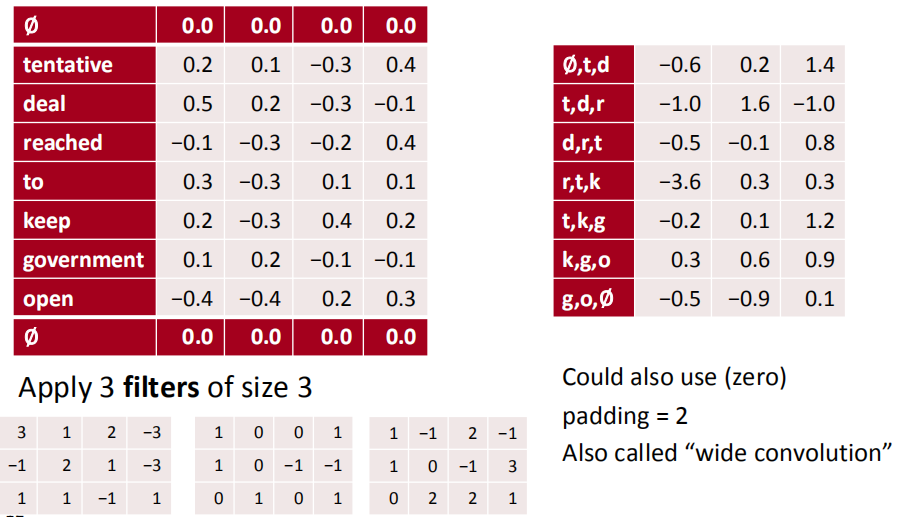

如果用1-Max Pooling, 得到的池化结果是:
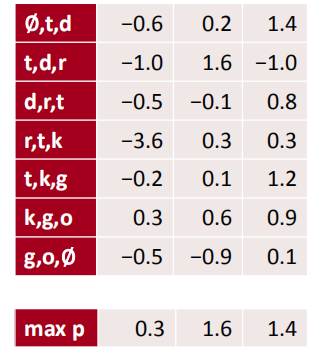


而如果用k-Max Pooling,就可以得到下面这样的结果，这里取$k=2$:
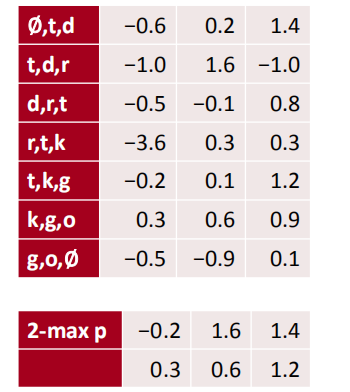

除此以外，卷积层本身也可以进行改进，常见的改进方式，是采用扩张卷积神经网络（Dilated Convolution,也称为空洞卷积网络）取代池化层，以获得更大的感受野，下图是普通卷积和扩张卷积的一个示意图:

普通卷积,可以认为是Dilation Rate =1的一种扩张卷积特例：
![norm_cnn.gif](norm_cnn.gif)


扩张卷积， Dilation rate = 2![](dilated_cnn.gif)

一般在使用空洞卷积时，我们将随着网络深度 $i$ 的增加而指数级地增大 $d$（扩张系数dilation rate)，即 $d=O(2^i)$。这确保了卷积核在有效历史信息中覆盖了所有的输入，同样也确保了使用深度网络能产生极其长的有效历史信息。下图中，各卷积层的输入像素的间距由1-2-4-8，虽然没有池化层，但是随着层数越深，覆盖的原始输入信息依旧在增加。也就是我们通常卷积核与输入的一个区域的维度大小保持一致，但是去掉池化层后，我们随着深度增加，卷积核的所能覆盖的输入区域扩展一倍。
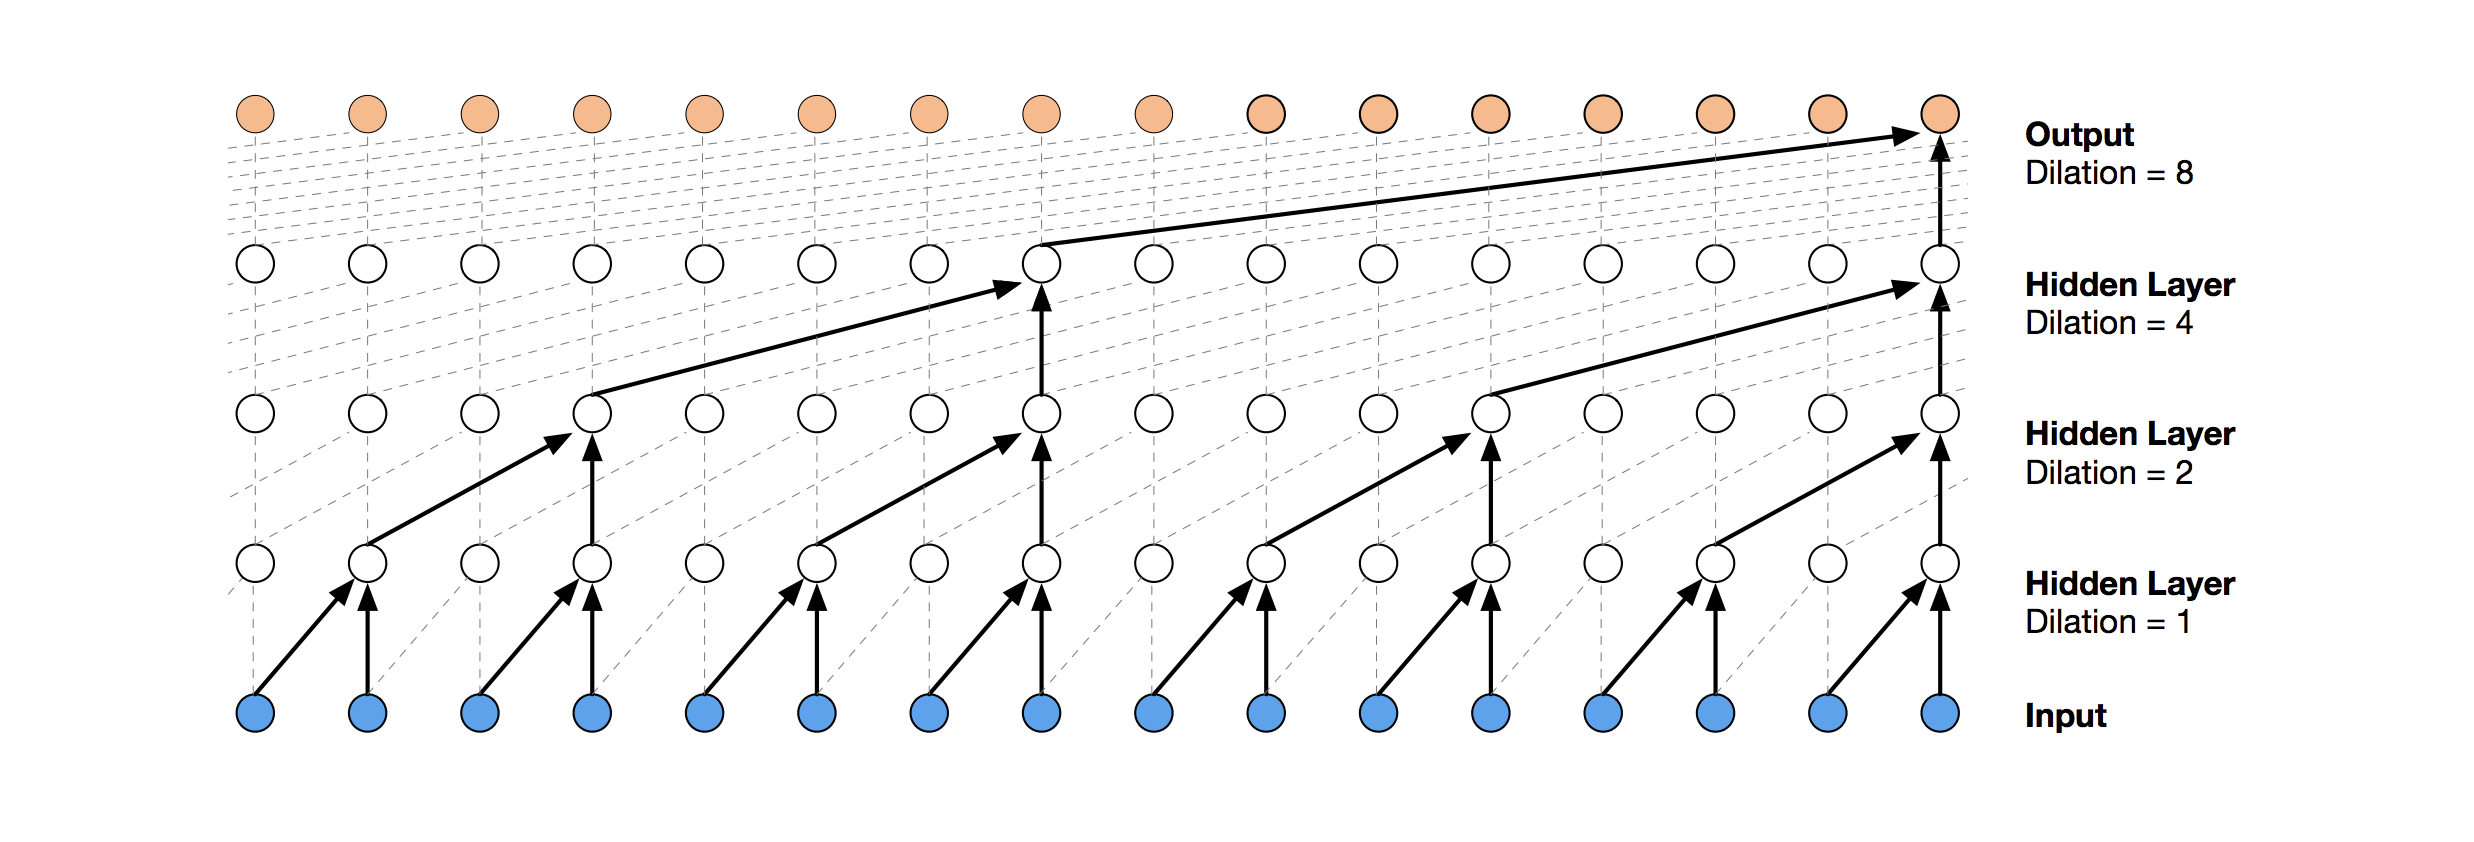

需要注意的，是上面每一层的输出节点数，都等于输入的时间步数，这是通过从下到上，不同层进行不同的padding实现的(分别是2,3,8），padding的示意如下图所示,这种padding方式被称为'causal', 而一般的卷积网络中，padding方式为'same'：
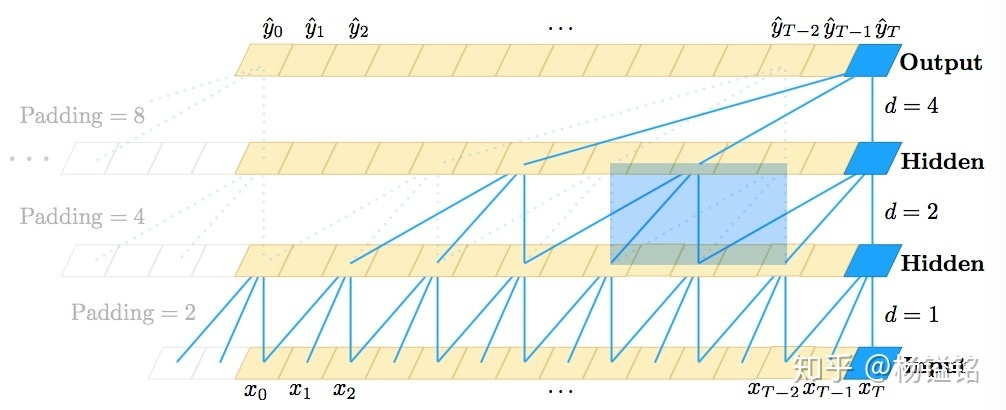

如果用Keras来实现上面的卷积模型，代码如下面所示:

In [10]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(4)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

model = Model(history_seq, x )

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
__________

在2018年，CMU的Shaojie Bai等人综合了以前卷积网络在时序数据处理中的改进，提出了一种叫做时间卷积网络(Temporal Convolutional Network)的卷积神经网络结构，在很多任务中取得了超过RNN网络的效果。主要的网络设计，包含了扩张卷积网络，并设计了一种类似ResNet中残差块的结构，如下图所示：
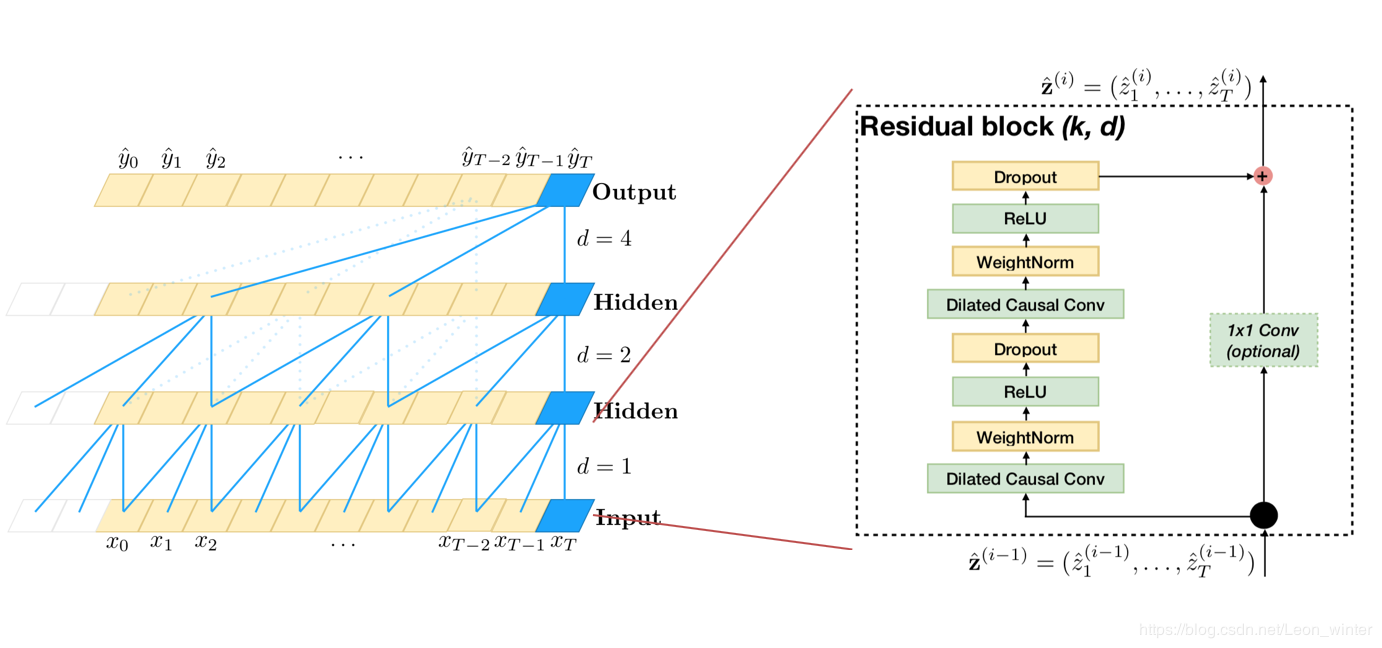


可以看出来，残差结构替代了层与层之间的简单连接，由于$x$和$F(x)$之间的通道数可能不一样，所以这里设计了一个$1×1 Conv$来对$x$做一个简单的变换，使得变换后的$x$与$F(x)$可以相加。注意每一层每个时刻只有一个网格并不代表这一时刻的通道数等于1。


在github上有一个[开源的项目](https://github.com/philipperemy/keras-tcn)，使用Keras实现了TCN网络，使用起来也很方便。

# 使用卷积网络进行句子语义匹配

使用卷积网络进行句子语义匹配的方法有很多，比如2015年，哈尔滨工业大学和华为诺亚实验室发表的论文"[Convolution Neural Network Architectures for Matching Natural Language Sentences](https://arxiv.org/pdf/1503.03244.pdf)" 提出了两种不同的卷积网络模型Arc-I和Arc-II,用于句子匹配任务:

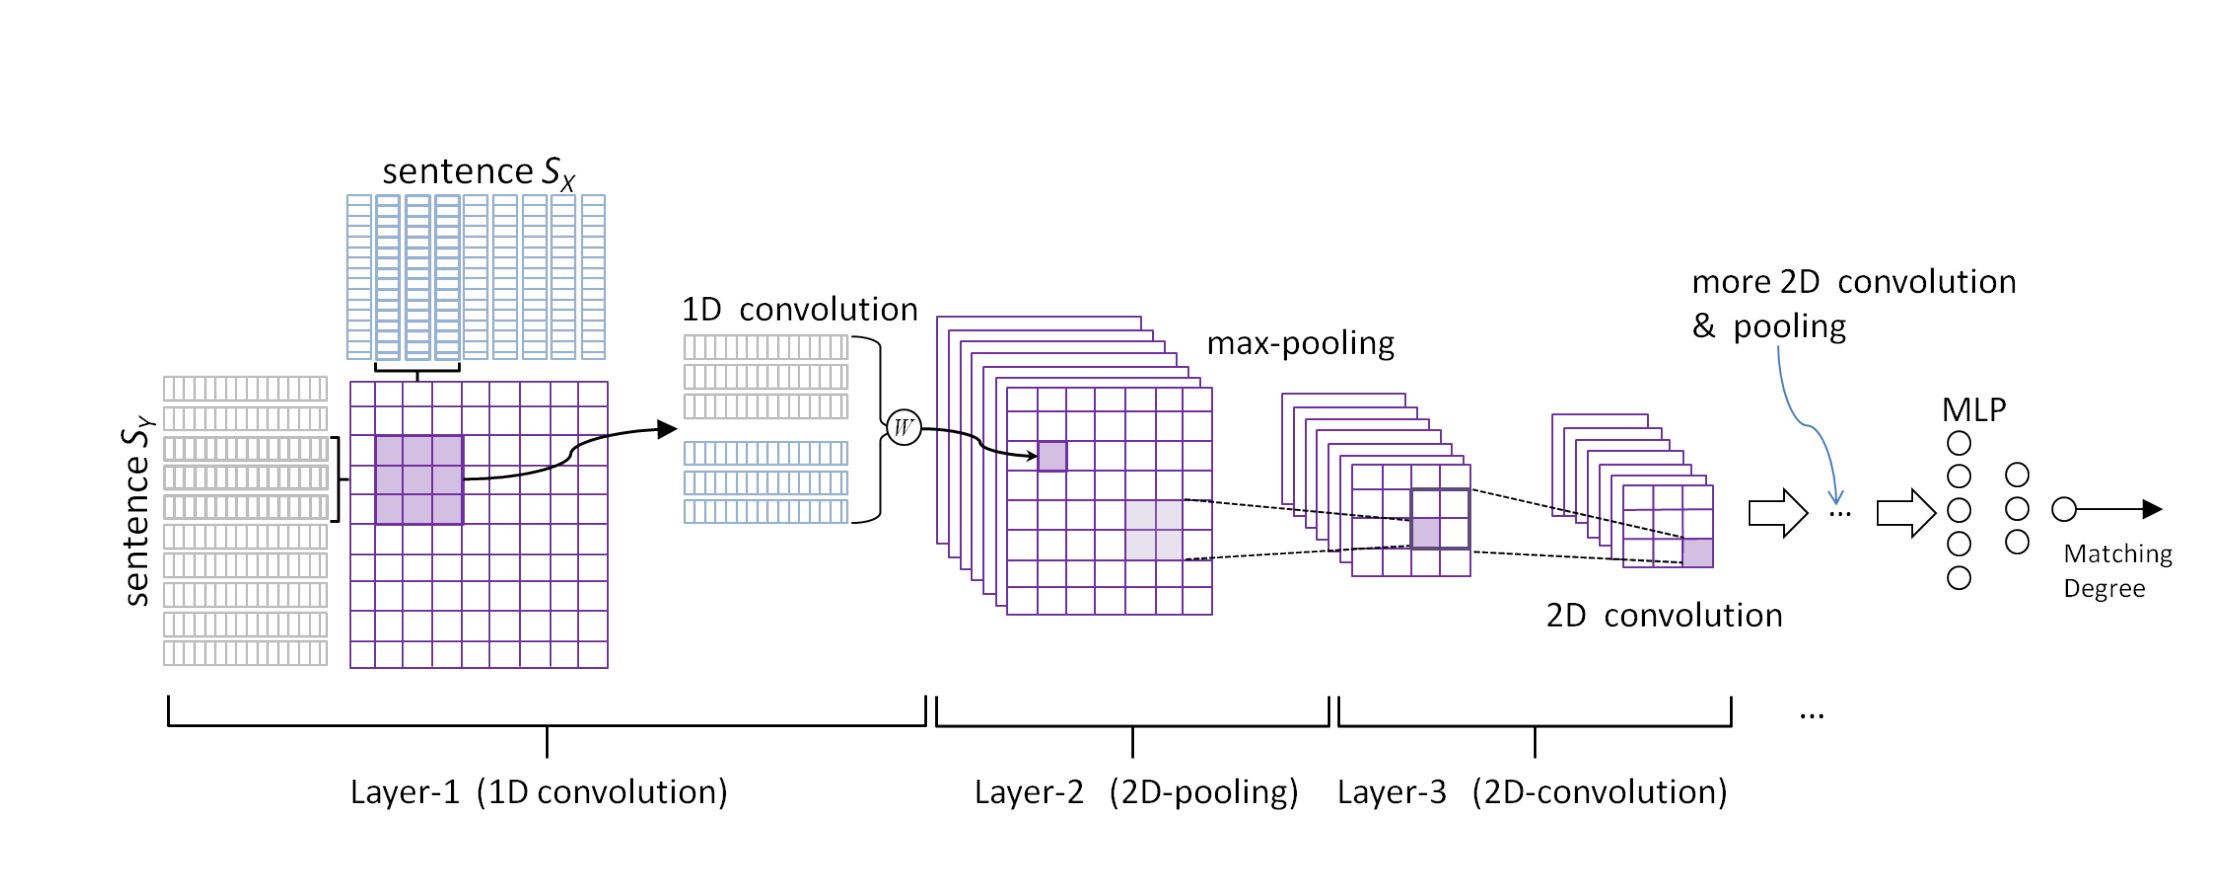

其中,ARC-II 的模型结构如上图所示，假设两个句子的长度都是N，embedding的维度为D，那么用一个3*3的卷积核在一个N*N的图片上进行扫描，每次扫描横向3个格子，纵向3个格子，分别代表两个句子对应的词，然后取到6个词，共计6* D，然后卷积核的大小也为6*D ,卷积核与被选中的词，进行点乘相加(此处没有激活函数)，最终得到一个值，移动3*3的卷积核，最终得到一个卷积的图片。


## 模型设计

我们这里使用的，是一个比较简单的卷积网络模型，整体的模型框架，跟上一节使用词向量进行句子语义匹配的模型一致，如下图所示:


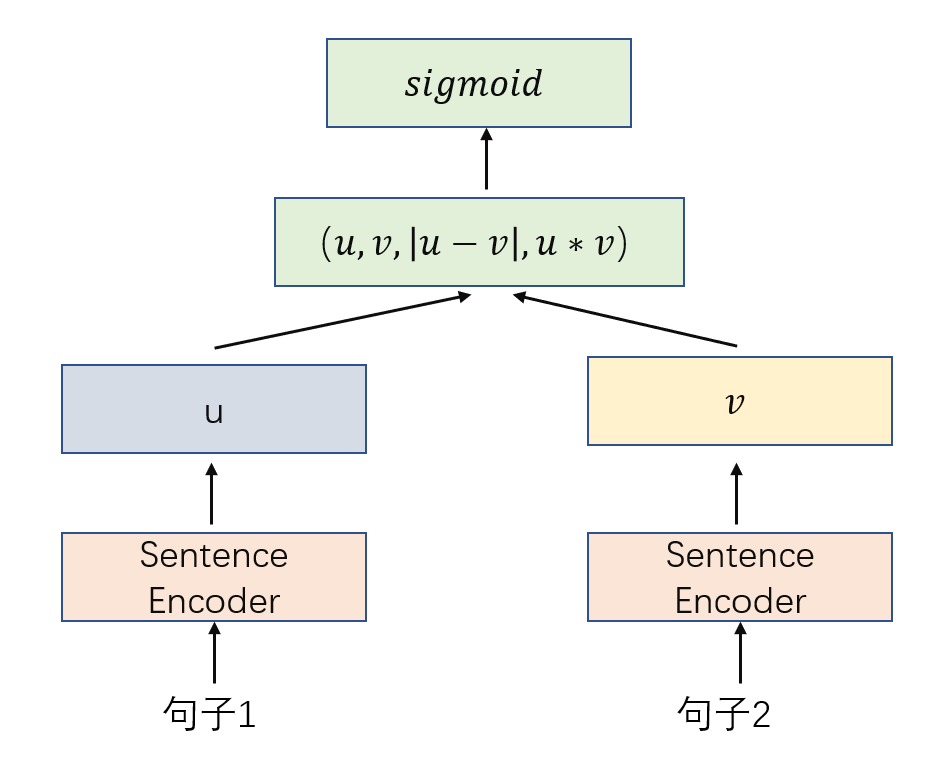

但在这里，我们使用的Setence Encoder是一个卷积网络，具体来说，我们会对左右边的两个句子分词以后，产生句子的词向量矩阵（每个句子产生一个二维句子，形状为句子中含有的词数 * 词向量维度），然后采用同一个卷积网络对左右两个句子的向量矩阵进行一维卷积（卷积核大小分别为2,3,4,5,6,7，每个卷积核的数量为100个），然后采用MaxPooling进行池化，产生出一个固定长度的向量$u$,向量$v$来代表左右两边的句子，再对这两个向量分别计算差的绝对值和相乘，拼接起来作为输入，最后以一个sigmoid作为输出。

首先，让我们先定义CNN模型：

In [3]:
from keras import Input, Model
from keras import backend as K
from keras.layers import Lambda, Dense
from keras.layers import concatenate, multiply, Dense
from keras import layers

ImportError: cannot import name 'Model'

In [8]:
def shard_cnn_encoder(input_shape,cnn_filters=128):
    
    # Input Layer
    _input = Input(shape=input_shape)    
    
    max_sent_len,dim_size = input_shape
    # Conv Layer
    convs = []
    filter_sizes = [2,3,4,5,6,7]
        
    for size in filter_sizes:
        l_conv = layers.Conv1D(filters = cnn_filters,kernel_size=size, activation='relu')(_input)
        l_pool = layers.MaxPooling1D(max_sent_len-size+1)(l_conv)
        l_pool = layers.Flatten()(l_pool)
        convs.append(l_pool)
    
    sentence_rep = layers.concatenate(convs, axis=1)   
  
    shared_model = Model(_input, sentence_rep, name='cnn_shared_model')

    return shared_model

In [9]:
def build_siamese_cnn_model(dim_size=200,max_sent_len=16):    
    left_input = Input(shape=(max_sent_len,dim_size), dtype='float32', name="left_x")
    right_input = Input(shape=(max_sent_len,dim_size), dtype='float32', name='right_x')
    
    shard_model = shard_cnn_encoder((max_sent_len,dim_size))    
    
    u_input = shard_model(left_input)
    v_input = shard_model(right_input)
    
    u_sub_v = Lambda(lambda x: K.abs(x[0] - x[1]))([u_input, v_input])
    u_mul_v = multiply([u_input, v_input])
    
    u_concat_v = concatenate([u_input, v_input, u_sub_v, u_mul_v])
    
    #dense = Dense(dense_unit, activation='relu')(u_concat_v)
    similarity = Dense(1, activation='sigmoid')(u_concat_v)
    
    model = Model([left_input, right_input], similarity)
    print(model.summary())
    return model

In [10]:
model = build_siamese_cnn_model()

W0419 13:36:26.493719 12052 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0419 13:36:26.531718 12052 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_x (InputLayer)             (None, 16, 200)      0                                            
__________________________________________________________________________________________________
right_x (InputLayer)            (None, 16, 200)      0                                            
__________________________________________________________________________________________________
cnn_shared_model (Model)        (None, 768)          691968      left_x[0][0]                     
                                                                 right_x[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768)          0           cnn_shared_model[1][0]           
          

我们用Adam优化器来优化这个模型，学习率为1e-3, 训练16个轮次，采用在验证集上性能最好的作为最后的模型：

In [11]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

In [12]:
def train_model(model, train_x, train_y, dev_x, dev_y,checkpointpath,lr=1e-3,batch_size=128,epochs=16):
    adam = Adam(lr=lr)
    model.compile(loss='binary_crossentropy',
                       optimizer=adam,
                       metrics=['accuracy'])    
    checkpoint_callback = ModelCheckpoint(checkpointpath,
                                          monitor='val_acc',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='auto',
                                          period=1)
    model.fit(train_x, train_y,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(dev_x, dev_y),
               shuffle=True,
               callbacks=[checkpoint_callback])


再定义一个预测方法，使用训练好的模型在测试集上进行预测：

In [13]:
def model_predict(model, test_x, test_y=None,predict_batchsize=128):    
    predict_y = model.predict(test_x, batch_size=predict_batchsize)[:, 0]
    if test_y.any():
        predict_y[predict_y >= 0.5] = 1
        predict_y[predict_y < 0.5] = 0
        print(classification_report(test_y, predict_y))

## 生成数据

接下来我们开始进行准备工作，从输入的训练文件、验证文件和测试文件中，产生出模型所需要的输入数据和输出数据。

首先我们让结巴分词(jieba)载入一个自定义词典，这个词典是根据腾讯词向量文件生成的，去除了腾讯词向量中的一些特殊词（如数量词）和词频极低的词（腾讯的词向量文件中没有包含词频信息，这里采用开源的wordfreq项目来产生每个单词的词频，该项目可估算多个语种的单词词频）,这个词典包含了大约700多万个单词，在实际应用中，可以根据需求再进行精简。

In [14]:
import jieba

dictfile='tc_min.dict'
# jieba 加载自定义词典
jieba.load_userdict(dictfile)

Building prefix dict from the default dictionary ...
I0419 13:36:36.765065 12052 __init__.py:113] Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wanghao\AppData\Local\Temp\jieba.cache
I0419 13:36:36.769069 12052 __init__.py:133] Loading model from cache C:\Users\wanghao\AppData\Local\Temp\jieba.cache
Loading model cost 1.413 seconds.
I0419 13:36:38.181656 12052 __init__.py:165] Loading model cost 1.413 seconds.
Prefix dict has been built successfully.
I0419 13:36:38.182657 12052 __init__.py:166] Prefix dict has been built successfully.


然后我们再载入之前的Annoy索引和单词索引：

In [23]:
from annoy import AnnoyIndex

def init_index(annoy_indexfile = 'tc_index_build10.ann.index',word2indexfile='tc_word_index.json'):
    # 我们用保存好的索引文件重新创建一个Annoy索引, 单独进行加载
    annoy_index = AnnoyIndex(200)
    annoy_index.load(annoy_indexfile)
    
    with open(word2indexfile, 'r') as fp:
        word2index = json.load(fp)

    #准备一个反向id==>word映射词表
    index2word = dict([(value, key) for (key, value) in word2index.items()])
    
    return annoy_index,word2index,index2word

In [24]:
annoy_index,word2index,index2word = init_index()

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """


In [25]:
word2index['你好']

1241

接下来我们将各数据集的数据进行加载，形成训练数据集、验证数据集和测试数据集，首先定义一个加载句子的方法:

In [26]:
def load_sentence_data(file_path):
    sentences1 = []
    sentences2 = []
    labels = []
    with open(file_path, 'r',encoding='utf8') as f:
        for line in f:
            s1, s2, label = line.split('\t')
            if not label:
                continue
            labels.append(int(label))
            sentences1.append(s1)
            sentences2.append(s2)
    return sentences1, sentences2, labels

然后我们定义一下LCQMC,CCKS和ATEC这三个数据集的地址：

In [27]:
from pathlib import Path

dataset_path = '../datasets/sentence-similarity-zoo-master/data'

LCQMC = [
    'LCQMC/processed/train.tsv',
    'LCQMC/processed/dev.tsv',
    'LCQMC/processed/test.tsv',
    ]

CCKS = [
    'CCKS/processed/train.tsv',
    'CCKS/processed/dev.tsv',
    'CCKS/processed/test.tsv',
    ]

ATEC = [
    'ATEC/processed/train.tsv',
    'ATEC/processed/dev.tsv',
    'ATEC/processed/test.tsv',
    ]

CORPUS = [
    (LCQMC,'LCQMC'),
    (CCKS, 'CCKS'),
    (ATEC, 'ATEC')    
    ]

定义一个方法，将文本转化成整数的单词索引的序列:

In [28]:
import numpy as np

def texts_to_sequences(sentences):        
    
    seq_len = len(sentences)
    sequences = []

    for sentence in sentences:
        seq_list = [word2index[token] for token in list(jieba.cut(sentence))
                     if token in word2index.keys()]
        sequences.append(seq_list)
        
    return np.array(sequences)
    

定义一个方法，将句子的集合转化成二维的词向量矩阵，形状为（句子数量，词向量维度）:

In [30]:
def sequences_to_embeddings(sequences,embed_index = annoy_index,dim_size=200):
   
    seq_num,seq_len = sequences.shape
    embeddings = np.zeros((seq_num,seq_len,dim_size))    
    items = embed_index.get_n_items()
    i = 0 
    for seq in sequences:
        new_sequence = np.array([embed_index.get_item_vector(wordindex) if wordindex<items else embed_index.get_item_vector(0) 
                                 for wordindex in seq])
        embeddings[i] = new_sequence
        i = i+1
        
    return embeddings


这里产生模型训练和预测所需要的数据:

In [31]:
from keras_preprocessing.sequence import pad_sequences

def build_dataset(dataset,max_sent_len=16):
    s1,s2,labels = load_sentence_data(dataset)        
    
    left_X = pad_sequences(texts_to_sequences(s1), max_sent_len)
    right_X = pad_sequences(texts_to_sequences(s2), max_sent_len)
    
    left_X = sequences_to_embeddings(left_X)
    right_X = sequences_to_embeddings(right_X)

    Y = np.array(labels)
    
    return [left_X, right_X], Y

## 模型训练

定义好了以上方法以后，我们就开始进行训练了，训练好的模型在测试集上进行验证:

In [35]:
import time

def evaluate(dataset,checkpoint):    
    
    dataset_dir = Path(dataset_path)
    train_file = dataset_dir / dataset[0]
    dev_file = dataset_dir / dataset[1]
    test_file = dataset_dir / dataset[2]   
    
    train_x, train_y = build_dataset(train_file)
    dev_x, dev_y = build_dataset(dev_file)
    test_x, test_y = build_dataset(test_file)
    
    start = time.time()
    model = build_siamese_cnn_model()
    
    
    train_model(model, train_x, train_y,dev_x, dev_y,checkpointpath=checkpoint )
    
    stop = time.time()

    print("time for train model = %.2f s" % (float(stop - start)))
    
    start = time.time()
    
    model.load_weights(checkpoint)
    
    model_predict(model,test_x,test_y)
    
    stop = time.time()

    print("time for predict = %.2f s" % (float(stop - start)))
    

In [36]:
for data in CORPUS:
    print('----- DataSet:{0}---------'.format(data[1]))
    checkpoint = "siamese_cnn_"+data[1] + "_best.h5"
    evaluate(data[0],checkpoint)

----- DataSet:LCQMC---------


W0419 14:40:41.102363 12052 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0419 14:40:41.156363 12052 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0419 14:40:41.182365 12052 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_x (InputLayer)             (None, 16, 200)      0                                            
__________________________________________________________________________________________________
right_x (InputLayer)            (None, 16, 200)      0                                            
__________________________________________________________________________________________________
cnn_shared_model (Model)        (None, 768)          691968      left_x[0][0]                     
                                                                 right_x[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 768)          0           cnn_shared_model[1][0]           
          

W0419 14:40:43.803875 12052 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 238766 samples, validate on 8802 samples
Epoch 1/16
238766/238766 [==============================] - 654s 3ms/step - loss: 0.4055 - acc: 0.8129 - val_loss: 0.5642 - val_acc: 0.7255
Epoch 2/16
238766/238766 [==============================] - 542s 2ms/step - loss: 0.2847 - acc: 0.8811 - val_loss: 0.5984 - val_acc: 0.7392
Epoch 3/16
238766/238766 [==============================] - 549s 2ms/step - loss: 0.2057 - acc: 0.9189 - val_loss: 0.5707 - val_acc: 0.7712
Epoch 4/16
238766/238766 [==============================] - 523s 2ms/step - loss: 0.1453 - acc: 0.9463 - val_loss: 0.6555 - val_acc: 0.7745
Epoch 5/16
238766/238766 [==============================] - 506s 2ms/step - loss: 0.1088 - acc: 0.9614 - val_loss: 0.7699 - val_acc: 0.7670
Epoch 6/16
238766/238766 [==============================] - 497s 2ms/step - loss: 0.0873 - acc: 0.9703 - val_loss: 0.7914 - val_acc: 0.7789
Epoch 7/16
238766/238766 [==============================] - 497s 2ms/step - loss: 0.0743 - acc: 0.9753 - val_l

Train on 132486 samples, validate on 16561 samples
Epoch 1/16
132486/132486 [==============================] - 277s 2ms/step - loss: 0.4169 - acc: 0.8306 - val_loss: 0.3842 - val_acc: 0.8389
Epoch 2/16
132486/132486 [==============================] - 259s 2ms/step - loss: 0.3332 - acc: 0.8590 - val_loss: 0.3435 - val_acc: 0.8563
Epoch 3/16
132486/132486 [==============================] - 241s 2ms/step - loss: 0.2463 - acc: 0.9015 - val_loss: 0.3032 - val_acc: 0.8788
Epoch 4/16
132486/132486 [==============================] - 402s 3ms/step - loss: 0.1662 - acc: 0.9379 - val_loss: 0.3093 - val_acc: 0.8781
Epoch 5/16
132486/132486 [==============================] - 526s 4ms/step - loss: 0.1071 - acc: 0.9629 - val_loss: 0.2827 - val_acc: 0.9059
Epoch 6/16
132486/132486 [==============================] - 444s 3ms/step - loss: 0.0661 - acc: 0.9795 - val_loss: 0.3537 - val_acc: 0.9079
Epoch 7/16
132486/132486 [==============================] - 421s 3ms/step - loss: 0.0422 - acc: 0.9881 - val_

可以看到，这样一个简单的CNN双生子模型，可以在句子匹配任务上取得不错的结果:


|LCQMC(F1)|CCKS(F1)|ATEC(F1)|
|-|-|-|
|0.78|0.89|0.91|

比较之前采用SIF句向量的模型，在这个任务上有明显的提升:

|LCQMC(F1)|CCKS(F1)|ATEC(F1)|
|-|-|-|
|0.74|0.81|0.87|


从计算速度上来看，这样一个CNN双生子模型，在我的笔记本上进行一个句子对的计算，时间为0.5~2ms，比SIF模型要慢一些(大约慢50倍左右)。如果进行优化的话(如针对Intel处理器采用OpenVINO工具进行优化，或是针对英伟达GPU采用TensorRT工具进行优化)，应该可以有明显的提升空间